<a href="https://colab.research.google.com/github/JardiT/DL_1920/blob/master/codes/2_homework/exercise2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hand-in 2

# Exercise 2

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Choose which device to use
use_cuda = True

if use_cuda and torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

device

device(type='cuda')

### Download the data

In [3]:
# Apply transformations to the data points before passing them to the network
transform = transforms.Compose([transforms.ToTensor(),  # Transform the data to torch tensors of shape (28, 28, 1), corresponding to 28 * 28 pixels with 1 channel (1 value per pixel that is)
                                transforms.Normalize((0.1307,), (0.3081,)),  # Normalize the images (mean and std for MNIST dataset found online)
                                ])

# Download the MNIST train dataset (used to train the network)
trainset = torchvision.datasets.MNIST(root='./data_mnist',
                                      train=True,
                                      download=True,
                                      transform=transform  # Apply the defined transformation on the data
                                      )

# Download the MNIST test dataset (used to evaluate the trained network)
testset = torchvision.datasets.MNIST(root='./data_mnist',
                                     train=False,
                                     download=True,
                                     transform=transform
                                     )

batch_size = 128
w, h, c = 28, 28, 1  # Width, Height, Nr. of channels for the input images
k = 10  # Number of output classes

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=True,  # Shuffle the dataset for random ordering of train samples
                                          )

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         )



### Defining the MLP architecture

In [4]:
class MLP(nn.Module):
  def __init__(self,
               input_size,  # Size of the input. Here we will first flatten the image to a single vector with the 3 * 32 * 32 values in the image 
               layer_sizes,  # A tuple containing the sizes of the hidden layers of the neural network. So to create a NN with two hidden layers with 32 neurons in each layer you'd set layer_sizes=(32,32)
               output_size):  # The size of the network output. CIFAR10 has 10 output classes
    super(MLP, self).__init__()
    shape = (input_size,) + tuple(layer_sizes) + (output_size,)
    self.layers = nn.ModuleList([nn.Linear(shape[i], shape[i + 1]) for i in range(len(shape) - 1)])  # Store the layers in a ModuleList object so they are recognized by pytorch as submodules of this model

  def forward(self, x):
    for layer in self.layers[:-1]:  # Apply relu activation to all but the last layer in the network
      x = F.relu(layer(x))
    return self.layers[-1](x)

In [5]:
net = MLP(w * h, (128, 128), k).to(device)  # Create a new dense neural network with two hidden layers of size 128

print(net)

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


### Choose the criterion and optimizers

In [6]:
criterion = nn.CrossEntropyLoss()

optimizerSGD = torch.optim.SGD(net.parameters() , lr=0.01)
optimizerAdam = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9,0.999), eps=1e-08)

### Train the network with SGD

In [7]:
num_epochs = 10

test_acc = np.zeros(num_epochs+1)
# Evaluate the untrained model on the test set
correct_total = 0
for i, (x_batch, y_batch) in enumerate(testloader):
  x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move the data to the device that is used

  y_pred = net(x_batch.view(-1, w * h))
  y_pred_max = torch.argmax(y_pred, dim=1)

  correct_total += torch.sum(torch.eq(y_pred_max, y_batch)).item()

test_acc[0] = correct_total / len(testset.data)
print(f'epoch: {0}, time: {0:.3f}s, Test accuracy: {test_acc[0]:.3f}')

start = time.time()
for epoch in range(1, num_epochs + 1):
  # Iterate through the entire train set
  for i, (x_batch, y_batch) in enumerate(trainloader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move the data to the device that is used

    optimizerSGD.zero_grad()  # Set all currenly stored gradients to zero 

    y_pred = net(x_batch.view(-1, w * h))

    loss = criterion(y_pred, y_batch)

    loss.backward()

    optimizerSGD.step()

    # Compute relevant metrics
        
    y_pred_max = torch.argmax(y_pred, dim=1)  # Get the labels with highest output probability

    correct = torch.sum(torch.eq(y_pred_max, y_batch)).item()  # Count how many are equal to the true labels

    elapsed = time.time() - start  # Keep track of how much time has elapsed
    
  # Evaluate the model on the test set
  correct_total = 0
  for i, (x_batch, y_batch) in enumerate(testloader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move the data to the device that is used

    y_pred = net(x_batch.view(-1, w * h))
    y_pred_max = torch.argmax(y_pred, dim=1)

    correct_total += torch.sum(torch.eq(y_pred_max, y_batch)).item()

  test_acc[epoch] = correct_total / len(testset.data)
  print(f'epoch: {epoch}, time: {elapsed:.3f}s, Test accuracy: {test_acc[epoch]:.3f}')

epoch: 0, time: 0.000s, Test accuracy: 0.163
epoch: 1, time: 9.681s, Test accuracy: 0.883
epoch: 2, time: 20.301s, Test accuracy: 0.908
epoch: 3, time: 31.289s, Test accuracy: 0.917
epoch: 4, time: 42.335s, Test accuracy: 0.928
epoch: 5, time: 53.548s, Test accuracy: 0.931
epoch: 6, time: 64.012s, Test accuracy: 0.937
epoch: 7, time: 75.069s, Test accuracy: 0.940
epoch: 8, time: 85.855s, Test accuracy: 0.944
epoch: 9, time: 96.545s, Test accuracy: 0.948
epoch: 10, time: 107.132s, Test accuracy: 0.951



### Plot test_acc

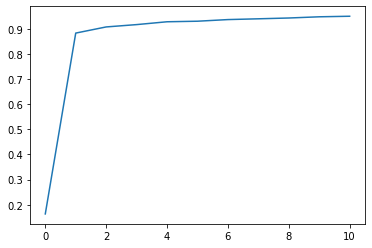

In [8]:
%matplotlib inline

epochs = np.arange(0,num_epochs+1)
plt.plot(epochs,test_acc)
